# Topic extraction: visualizing models

We load a specific saved model, and prepare its data for `pyLDAvis`.

In [36]:
%load_ext autotime

# MODEL_UUID = 'f9a183e0-cc88-4927-8f02-397029ead747' # K=35, 200k v1
# MODEL_UUID = 'b788d5cf-96f9-42c9-a40f-29b7d5c97a8d' # K=35, 200k v1
# MODEL_UUID = '075a5978-5f1d-404f-b364-5a09f25748be' # K=57, 200k v1
# MODEL_UUID = '77a4e5c1-c36c-4fe8-a193-456b399a05d2' # K=35, 400k v2
MODEL_UUID = 'eb04d483-c4eb-434d-998c-70fd069530ab' # K-92, 400k v2

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 1 ms


In [37]:
import metadata as md
import tomotopy as tp

meta = md.session.query(md.Model).filter_by(uuid=MODEL_UUID).first()
model = getattr(tp, meta.klass).load(meta.path)

print('Loaded model with k=%d, c_v=%.3f' % (model.k, meta.c_v))

Loaded model with k=92, c_v=0.609
time: 9.19 ms


In [38]:
import numpy as np

topic_term_dist = [model.get_topic_word_dist(k) for k in range(model.k)]
topic_term_dist = np.asarray(topic_term_dist)
topic_term_dist.shape

(92, 2430)

time: 3.26 ms


In [39]:
# load dataset, run inference
import pickle
from tqdm import tqdm

dataset = pickle.load(open(f'dataset.{meta.dataset}.pkl', 'rb'))
dataset_train = dataset['tokenised']['train']
# dataset_train = dataset['train']
documents = [model.make_doc(d) for d in tqdm(dataset_train)]

inference = model.infer(documents)
doc_topic_dists = np.asarray(inference[0])
doc_topic_dists.shape

100%|██████████| 293458/293458 [00:01<00:00, 220927.07it/s]


(293458, 92)

time: 35.5 s


In [40]:
doc_lengths = np.asarray([len(d) for d in dataset_train])

time: 37.3 ms


In [41]:
vocabulary = model.vocabs

time: 24.6 ms


In [42]:
tf_dict = dict.fromkeys(vocabulary, 0)
for d in dataset_train:
    for t in d:
        tf_dict[t] += 1

tf = [tf_dict[t] for t in vocabulary]

time: 1.25 s


In [8]:
import pyLDAvis
vis_data = pyLDAvis.prepare(
    topic_term_dists=topic_term_dist,
    doc_topic_dists=doc_topic_dists,
    doc_lengths=doc_lengths,
    vocab=vocabulary,
    term_frequency=tf,
    
    sort_topics=False,
#     start_index=0,
    lambda_step=0.1,
    mds='mmds',
)

time: 1min 7s


In [9]:
pyLDAvis.display(vis_data)

time: 38.3 ms


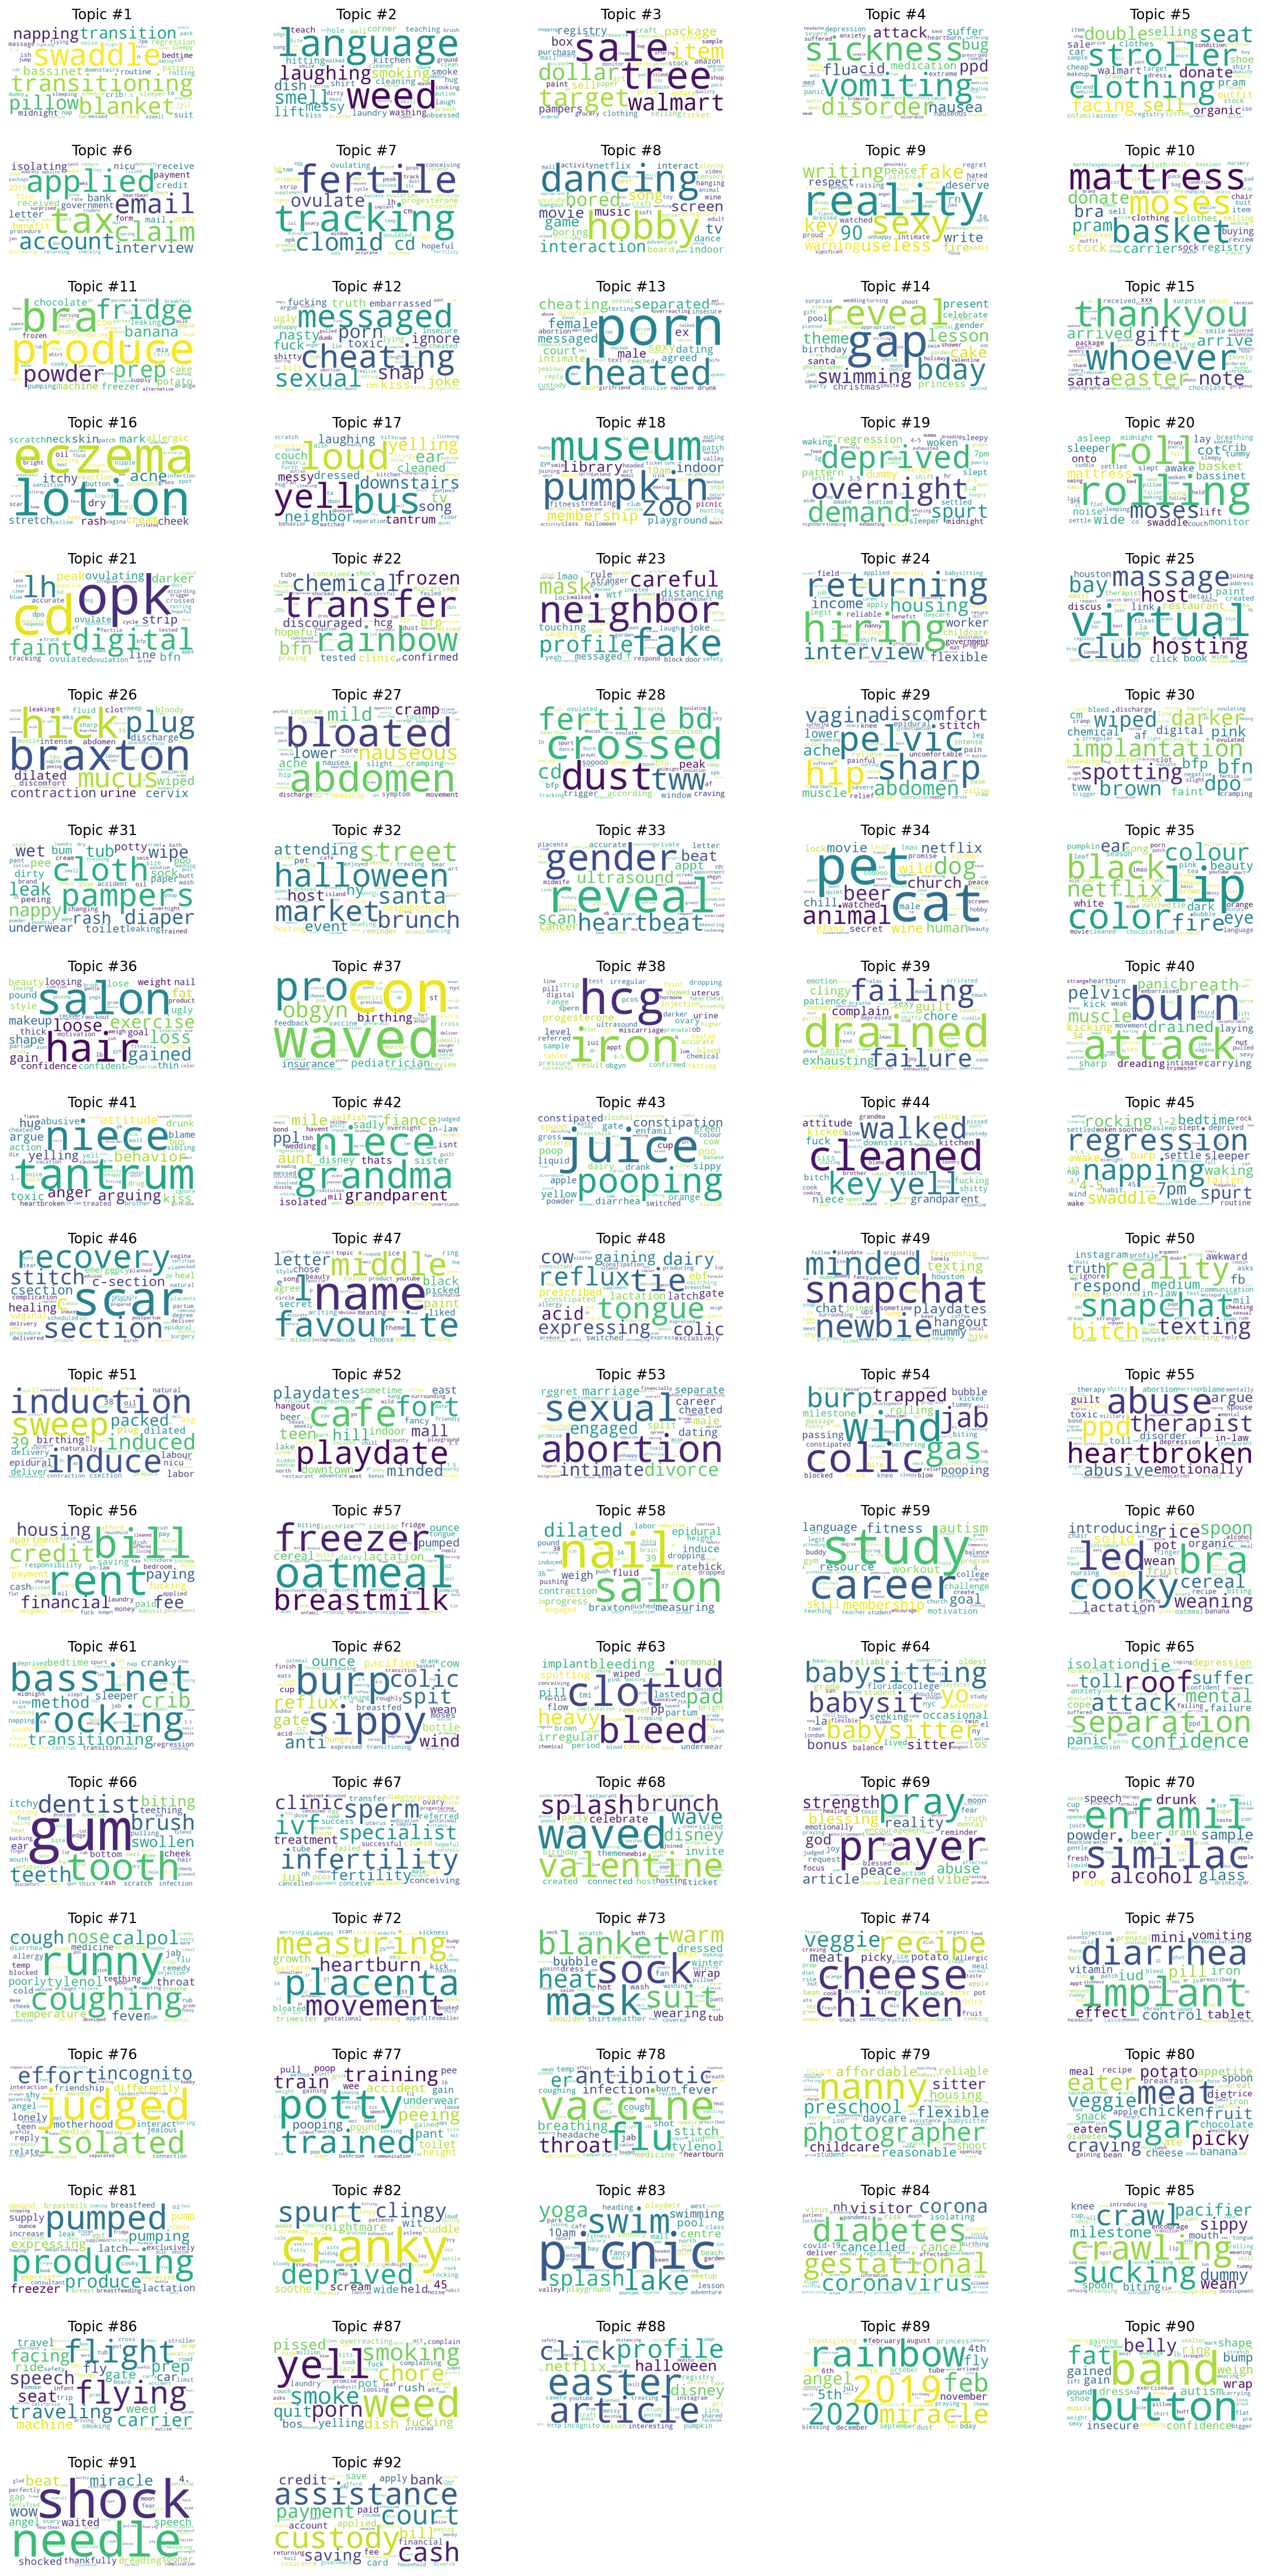

time: 32.6 s


In [43]:
%config InlineBackend.figure_format = 'retina'
import helpers as h
h.render_clouds(model)

In [44]:
# h.top_relevant_terms(model)[17]
# res = model.infer(documents)

time: 431 µs


In [51]:
# Find top posts

# inference = np.asarray(res[0])
# inference.argsort(axis=0)
# len(documents[3144].words)
# sorted(dataset['train'][3144])
# sorted(model.vocabs)
# documents[3144].words

# normalise inference results
# inference.sum(axis=1).T.shape
inference_n = doc_topic_dists / doc_topic_dists.sum(axis=1)[:, np.newaxis]
inference_s = inference_n.argsort(axis=0)

tpl_row = '''
    <tr>
        <td>{id}</td>
        <td><a href='https://admin2.teampeanut.com/posts/{post_id}' target='_blank'>#{post_id}</a></td>
        <td class='post-text'>{text:.255}</td>
    </tr>
'''

tpl_main = '''
    <!DOCTYPE html>
    <html>
        <head>
            <meta charset="utf-8"/>
        </head>
        <body>
            <style>
                body, h1, td {{
                    font-family: sans-serif;
                }}
                tr {{
                    border-top: 1px solid #ccc;
                }}
                td {{
                    padding: 1ex;
                }}
            </style>
            <h1>Topic {k}</h1>
            <table class='topics'>
                <thead>
                    <th>Dataset ID</th>
                    <th>Post ID</th>
                    <th>Text</th>
                </thead>
                <tbody>
                    {html_rows}
                </tbody>
            </table>
        </body>
    </html>
'''


from IPython.display import display, HTML
import os

for k in range(model.k):
    ids = inference_s[-10:, k]
#     print(ids)

    html_rows = []
    for id in ids:
        html_rows.append(tpl_row.format(
            id=id,
            post_id=dataset['ids']['train'][id],
            text=dataset['raw']['train'][id]
        ))
    html = tpl_main.format(
        k=k+1,
        html_rows=''.join(html_rows)
    )
    
#     display(HTML(html))
    parent = f'samples/{MODEL_UUID}'
    if not os.path.isdir(parent):
        os.mkdir(parent)
    with open(f'{parent}/topic-{k+1}.html', 'w') as f:
        f.write(html)

time: 3.86 s
